In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from time import time
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  # Needed to split the data
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData
import keras as keras
import yfinance as yf # Needed to utilize yfinance

In [26]:
print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version 2.1.0
Num GPUs Available:  0


In [27]:
class DDDQN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.f1 = tf.keras.layers.Flatten()
        self.d2 = tf.keras.layers.Dense(256, activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.d3 = tf.keras.layers.Dense(256, activation='relu')  
        self.bn3 = tf.keras.layers.BatchNormalization()  
        self.drop2 = tf.keras.layers.Dropout(0.3)  
        self.dv1 = tf.keras.layers.Dense(64, activation='relu')  # value hidden layer
        self.da1 = tf.keras.layers.Dense(64, activation='relu')  # actions hidden layer
        self.dv2 = tf.keras.layers.Dense(1, activation=None)  # value output
        self.da2 = tf.keras.layers.Dense(9, activation=None)  # actions output

    def call(self, input_data):
        x = self.d1(input_data)
        x = self.bn1(x)
        x = self.f1(x)
        x = self.d2(x)
        x = self.bn2(x)
        x = self.drop1(x)
        x = self.d3(x)
        x = self.bn3(x)
        x = self.drop2(x)
        v = self.dv1(x)
        v = self.dv2(v)
        a = self.da1(x)
        a = self.da2(a)
        Q = v + (a - tf.math.reduce_mean(a, axis=1, keepdims=True))
        return Q

    # this is the same as the call() method but only for the actions outputs
    def advantage(self, state):  
        x = self.d1(state)
        x = self.f1(x)
        x = self.d2(x)
        x = self.drop1(x)
        x = self.d3(x)
        x = self.drop2(x)
        a = self.da1(x)
        a = self.da2(a)
        return a

In [28]:
class ExpReplay():
    def __init__(self, num_features, window_size, buffer_size = 1000000):
        self.num_features = num_features
        self.buffer_size = buffer_size
        self.state_mem = np.zeros((self.buffer_size, self.num_features, window_size), dtype=np.float32)
        # ones because we use these as indices later when selecting an action from a list
        self.action_mem = np.ones((self.buffer_size), dtype=np.int32)  
        self.reward_mem = np.zeros((self.buffer_size), dtype=np.float32)
        self.next_state_mem = np.zeros((self.buffer_size, self.num_features, window_size), dtype=np.float32)
        # we want to make sure we are aware if we sample a terminal memory to zero out future expected rewards for this time step.
        self.done_mem = np.zeros((self.buffer_size), dtype=bool) 
        self.counter = 0

    def add_exp(self, state, action, reward, next_state, done):
        """
        Add the results of an action to the memory. Record the state before the action, the action we took to get there, the reward after the action, the next state, and whether the action ended the game.
        """
        # by using mod operator, we ensure we overwrite old data when the buffer is full. (1000001 % 1000000 = 1)
        pointer = self.counter % self.buffer_size
        self.state_mem[pointer] = state
        self.action_mem[pointer] = action
        self.reward_mem[pointer] = reward
        self.next_state_mem[pointer] = next_state
        # done is a bool, where 1 is True and 0 is false. We subtract it from 1 here because we multiply it by future rewards to zero-out future rewards in terminal states
        self.done_mem[pointer] = 1 - int(done)
        self.counter += 1

    def sample_exp(self, batch_size=64):
        max_mem = min(self.counter, self.buffer_size)  # get the amount of filled memory or total memory size, whichever is less.
        # get a list (batch) of random indices between 0 and the number of filled spots in memory (max_mem). batch_size shows that we want a list of 64 random indices. replace=false means that we can't sample the same memory index twice.
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_mem[batch] # sample 64 states from memory using the random indices we saved in "batch"
        actions = self.action_mem[batch]
        rewards = self.reward_mem[batch]
        next_states = self.next_state_mem[batch]
        dones = self.done_mem[batch]
        return states, actions, rewards, next_states, dones

In [29]:
class Agent():
    def __init__(self, data_shape, num_episodes, window_size=4, gamma=0.99, update_interval=96, lr=0.01, min_epsilon=0.02):
        self.window_size = window_size
        self.data_shape = data_shape
        self.portfolio = [0, 0]  # [total eth, cash_held]
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.epsilon = 1.0
        self.min_epsilon = min_epsilon
        self.update_interval = update_interval
        self.trainstep = 0
        self.memory = ExpReplay(self.window_size, data_shape[1])
        self.batch_size = 64
        self.online_net = DDDQN()
        self.target_net = DDDQN()

        initial_learning_rate = lr
        decay_steps = self.num_episodes * self.data_shape[0] // 10  # You can adjust the divisor to control the decay rate
        decay_rate = 0.9  # You can adjust this value to control the decay rate
        lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.online_net.compile(loss='mse', optimizer=opt)
        self.target_net.compile(loss='mse', optimizer=opt) # we won't ever optimize this network for loss, since we are only copying weights from our online network every 100 steps

    def get_action(self, state, cash_balance):
        # create a random number between 0 and 1 and compare it to epsilon for our epsilon-greedy algorithm
        if tf.random.uniform([]) <= self.epsilon:
            # Select a random action out of the list of available actions
            if self.portfolio[0] > 0.01:  # if we have portfolio to sell
                return np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8])
            elif cash_balance > 0:  # if we have money to buy
                return np.random.choice([4, 5, 6, 7, 8])
            else:  # if we have neither
                action = 4 # hold
                return action
        else:
            # Select the action with the highest Q-value
            actions = self.online_net.advantage(np.array([state]))[0]
            if self.portfolio[0] > 0.01:
                action = tf.math.argmax(actions, axis=0).numpy()
            elif cash_balance > 0:
                action = tf.math.argmax(actions[4:], axis=0).numpy() + 1
            else:
                action = 4  # hold action
            return action
    
    def update_target(self):
        self.target_net.set_weights(self.online_net.get_weights()) # copies the weights of our target DQN from our online DQN (copies the network)

    def update_epsilon(self):
        # if self.epsilon > self.min_epsilon:
        #     b = self.min_epsilon**(1/(self.num_episodes*self.data_shape[0]))
        #     self.epsilon = b**self.trainstep
        epsilon_decay = (1.0 - self.min_epsilon) / (self.num_episodes * self.data_shape[0])
        self.epsilon = max(self.epsilon - epsilon_decay, self.min_epsilon)

    def train(self):
        # if we haven't filled our batch of 64 with enough experiences to fill our memory yet, we don't train our model. This way we don't train our model every single action, just every 64.
        if self.memory.counter < self.batch_size: 
            return 
        
        # every 100 steps, we update our target network. the 100 is set in the update_interval variable. This prevents us form "chasing our own tail", and improves the stability of our Deep Q Learning.
        if self.trainstep % self.update_interval == 0: 
            self.update_target()
        
        # Here we use experience replay buffers to sample our memory of past experiences.
        # In contrast to consuming samples online and discarding them thereafter, sampling from the stored experiences means they are less heavily correlated and can be re-used for learning.
        # Can we improve this with Prioritized Experience Replay? It improves by weighing the importance of different memories differently.
        states, actions, rewards, next_states, dones = self.memory.sample_exp(self.batch_size) # we sample 64 experiences from our memory since we are training in batches of 64 and not every time
        
        # feed-forward:
        # We calculate the possible Q values with our online network, then we calculate again the Q values with our target network and find which action has the highest Q value. (this is where double DQN comes in)
        # We then select the action with the best Q value determined by our online network, and use the Q value from the corresponding action in our target network to train our online network (minimizing loss).
        q_next_state_online_net = self.online_net.predict(next_states, verbose=0)  # equivalent to __call__()
        q_next_state_target_net = self.target_net.predict(next_states, verbose=0)
        
        max_action = tf.math.argmax(q_next_state_online_net, axis=1, output_type=tf.dtypes.int32).numpy()
        # Now that we know which action provided the maximum Q value according to our online network, we can train our online model using the Q value from the corresponding action in our target network.
        # 1. We predict the Q values for the action we actually took using our online network and save the values in q_predicted
        # 2. we copy q_predicted to q_target because of how Keras/TF calculates loss (we have to copy it to a fresh variable). By using np.copy, we zero out all losses associated with actions not taken  
        # 3. We update the Q values of q_target with the rewards we got from the action we actually took and the future value according to our target network (gamma, our discount rate, time the next step Q value)
        # 4. We update the weights of our online network by training it using this ^

        batch_index = tf.range(self.batch_size, dtype=tf.dtypes.int32)

        q_predicted = self.online_net.predict(states, verbose=0) # in our equation for the optimal Q function, we need to know the value of the action we actually took.
        q_target = np.copy(q_predicted) # We copy q_predicted to q_target because of how Keras/TF calculates loss. By using np.copy, we basically zero out all losses associated with actions not taken 

        # The Q value for each state in our batch, for the action we ACTUALLY took, is equal to the reward for that time step plus gamma times the Q value of the next step, according to our target network.
        # this q_target is the Q value we are chasing after with our estimates. It is the estimated "optimal" Q value based on the Bellman equation.
        q_target[batch_index, actions] = rewards + self.gamma * q_next_state_target_net[batch_index, max_action] * dones # if a state is done, done has been set to 0. This is because the expected future rewards for a terminal state is always 0.
                # ^ we subset our q_target array (remember: this is actually a copy of our predictions from the online network) by selecting 64 entries according to batch_index, then the best action according to actions.
                # it returns a 1d array of 64 elements with the best action per memory entry in the batch, which we replace with the reward and expected outcome according to our target network

        loss = self.online_net.train_on_batch(states, q_target)
        self.update_epsilon()
        self.trainstep += 1
        return loss

    def save_model(self):
        self.online_net.save("online_model.h5")
        self.target_net.save("target_model.h5")

    def calculate_reward(self, t, eth_df, eth_close_price_unscaled, amount_to_sell, initial_investment, trading_fee_rate, risk_adjustment):
                        ether_held, cash_held = self.portfolio
                        
                        scaled_close_price = eth_df["Close"].iloc[t]
                        unscaled_close_price = eth_close_price_unscaled["Close"].iloc[t]
                        value_of_eth_sold = unscaled_close_price * amount_to_sell
                        trading_fee = value_of_eth_sold * trading_fee_rate
                        cash_received = value_of_eth_sold - trading_fee
                        new_cash_held = cash_held + cash_received
                        new_ether_held = ether_held - amount_to_sell
                        
                        # Calculate portfolio value
                        portfolio_value = new_cash_held + (new_ether_held * unscaled_close_price) - initial_investment
                        
                        # Calculate risk-adjusted return
                        asset_weights = [new_cash_held / portfolio_value, new_ether_held * unscaled_close_price / portfolio_value]
                        asset_volatility = [eth_close_price_unscaled["Close"].pct_change().rolling(window=252).std().iloc[t] for asset in asset_weights]
                        portfolio_volatility = np.dot(asset_weights, asset_volatility)
                        risk_adjusted_reward = (portfolio_value - cash_held) / (portfolio_volatility * risk_adjustment)
                        
                        # Add some reward for selling if a sell flag was set?
                        
                        # Update portfolio
                        self.portfolio = [new_ether_held, new_cash_held]

                        return risk_adjusted_reward

    def trade(self, t, action, eth_df, eth_df_unscaled, initial_investment, trading_fee_rate, risk_adjustment):
        reward = 0
        eth_held, cash_balance = self.portfolio
        sell_percentages = [0.25, 0.5, 0.75, 1.0]
        buy_percentages = [0.25, 0.5, 0.75, 1.0]

        if action >= 0 and action <= 3 and eth_held > 0.01:
            print("Selling: " + str(sell_percentages[action]) + "% of portfolio at eth price " + str(eth_df_unscaled["Close"].iloc[t]))
            print("Current cash_balance: " + str(cash_balance))
            sell_percentage = sell_percentages[action]
            amount_to_sell = eth_held * sell_percentage

            while amount_to_sell > 0 and self.portfolio[0] > 0.01:
                scaled_item_cost = eth_df["Close"].iloc[t]
                unscaled_item_cost = eth_df_unscaled["Close"].iloc[t]
                print("Eth amount: " + str(eth_held))
                print("Current ask price: " + str(eth_df_unscaled["Close"].iloc[t]))
                print('----------------')

                reward = self.calculate_reward(t, eth_df, eth_df_unscaled, amount_to_sell, trading_fee_rate, risk_adjustment)

                eth_held, cash_balance = self.portfolio # Update portfolio after selling

                print("Amount Eth sold: " + str(amount_to_sell))
                print("Selling price: " + str(eth_df_unscaled["Close"].iloc[t]))
                print("Trading fee: " + str(trading_fee_rate * unscaled_item_cost))
                print("New Eth amount: " + str(eth_held))
                print("New cash_balance: " + str(cash_balance))
                amount_to_sell = 0
        elif action == 4:
            print("Hold: Price is " + str(eth_df_unscaled["Close"].iloc[t]))
            reward = -0.01
        elif action >= 5 and cash_balance >= 0:
            print("Buy Ether with: " + str(buy_percentages[action - 5]) + "% of cash_balance at Eth price " + str(eth_df_unscaled["Close"].iloc[t]))
            buy_percentage = buy_percentages[action - 5]
            eth_to_buy = (cash_balance * buy_percentage) / eth_df_unscaled["Close"].iloc[t]
            print("Current cash_balance: " + str(cash_balance))
            print("Current Eth amount: " + str(eth_held))
            print("Eth purchased: " + str(eth_to_buy))
            self.portfolio[0] += eth_to_buy
            self.portfolio[1] -= eth_df_unscaled["Close"].iloc[t] * eth_to_buy
            print("New cash_balance: " + str(self.portfolio[1]))
            # add some reward for buying if a buy flag is set?
        return reward
    
    def get_state(self, t, eth_df):
        num_rows = t - self.window_size + 1
        if num_rows >= 0:
            window = eth_df.iloc[num_rows : t + 1]
        else:
            repeated_first_row = pd.concat([pd.DataFrame(np.repeat(eth_df.iloc[[0]].values, -num_rows, axis=0), columns=eth_df.columns)])
            new_data = eth_df.iloc[0 : t + 1]
            window = pd.concat([repeated_first_row, new_data], ignore_index=True)  # prevents us from sampling data that doesn't exist at the start.
        return window

In [30]:
def get_crypto_data(start_date, end_date, split_date):
    try:
        train = pd.read_csv("Datasets/train_eth.csv", index_col=0)
        test = pd.read_csv("Datasets/test_eth.csv", index_col=0)
    except:
        df = HistoricalData('ETH-USD', 3600, start_date, end_date).retrieve_data()  # 3600 is the interval in seconds which is 1 hour
        split_row = df.index.get_loc(split_date)
        cols = df.columns.tolist()
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=cols)
        train = df[:split_row]
        test = df[split_row:]
        train.to_csv("Datasets/train_eth.csv")
        test.to_csv("Datasets/test_eth.csv")
    return train, test

In [31]:
def get_crypto_data(start_date, end_date):
    historic_data_df = HistoricalData('ETH-USD', 21600, start_date, end_date).retrieve_data()  # 3600 is the interval in seconds which is 1 hour
    cols = historic_data_df.columns.tolist()
    historic_data_df = pd.DataFrame(MinMaxScaler().fit_transform(historic_data_df), columns=cols)
    historic_data_df.to_csv("Datasets/train_eth.csv")
    return historic_data_df

In [32]:
# pre-collected data
def get_precollected_data(split_ratio=0.8):
    # try:
    historic_data = pd.read_csv("Datasets/eth_historical_data.csv", index_col=0)
    print('Pre-collected data loaded successfully.')
    # convert date to datetime if it isn't the index
    if historic_data.index.name != 'Date':
        historic_data['Date'] = pd.to_datetime(historic_data['Date'], infer_datetime_format=True)
        print('Date converted to datetime.')
        # set date as index
        historic_data = historic_data.set_index('Date')
        print('Date set as index.')
    # drop nan values
    historic_data = historic_data.dropna()
    print('NaN values dropped.')
    cols = historic_data.columns.tolist()
    train_unscaled, test_unscaled = train_test_split(historic_data, train_size=split_ratio,shuffle=False)
    train_scaled = pd.DataFrame(MinMaxScaler().fit_transform(train_unscaled), columns=cols)
    test_scaled = pd.DataFrame(MinMaxScaler().fit_transform(test_unscaled), columns=cols)
    print('Data split.')
    # set the index to the date
    train_unscaled = pd.DataFrame(train_unscaled,  columns=cols)
    test_unscaled = pd.DataFrame(test_unscaled,  columns=cols)
    # convert train_unscaled and test_unscaled to df with only the Close column
    train_unscaled = train_unscaled[['Close']]
    test_unscaled = test_unscaled[['Close']]

    train_unscaled.to_csv("Output/train_unscaled.csv")
    train_scaled.to_csv("Output/train_scaled.csv")
    print('Train data saved.')
    test_unscaled.to_csv("Output/test_unscaled.csv")
    test_scaled.to_csv("Output/test_scaled.csv")
    print('Test data saved.')
    return train_scaled, test_scaled, train_unscaled, test_unscaled
        
    # except:
    #     # throw error
    #     print("No pre-collected data found. Please run the data collection script first.")
    #     exit()

In [33]:
historic_data = pd.read_csv("Datasets/eth_historical_data.csv", index_col=0)

historic_data.head()

,Bitcoin,Crypto,Cryptocurrency,ETH,Crypto Ban,Crypto Bubble,Bull,Bear,Hack,Crypto Market,...,7day_Past_Mean_Price,Yesterday_Volume,3day_Past_Mean_Volume,7day_Past_Mean_Volume,Yesterday_Vol_USDT,3day_Past_Mean_Vol_USDT,7day_Past_Mean_Vol_USDT,RSI,RSI_BuySellFlag,EMA_BuySellFlag
Date,,,,,,,,,,,,,,,,,,,,,
7/19/2019,64,7,4,0,0,0,79,84,41,0,...,226.483728,9327816059,8773998943,8625351483,2.660702e+10,2.550249e+10,2.516096e+10,37.863434,0,0
7/20/2019,51,4,2,4,0,0,75,91,40,2,...,220.720930,7606433131,8303498393,8805268135,2.197717e+10,2.324585e+10,2.512160e+10,40.588868,0,0
7/21/2019,54,4,7,1,0,2,93,96,39,0,...,220.442745,7976245988,7422587329,8534802918,2.115336e+10,2.051297e+10,2.433822e+10,39.747640,0,0
7/22/2019,45,7,3,0,3,0,89,83,49,2,...,218.697604,6685082868,7000057592,8051255728,1.840836e+10,1.908170e+10,2.288130e+10,37.795917,0,0
7/23/2019,65,5,5,3,0,0,46,84,42,0,...,220.631867,6338843919,6666672774,7756894448,1.768336e+10,1.836875e+10,2.182387e+10,36.636155,0,0


In [34]:
INITIAL_INVESTMENT = 1000
NUM_EPISODES = 30
START_DATE = "2017-01-01-00-00"
END_DATE = "2020-01-01-00-00"
TESTING_SPLIT = "2022-01-01-00:00:00" # formatting is different here because of how historic_crypto indexes dataframes

In [35]:
def main():
    # train_df, test_df = get_crypto_data(START_DATE, END_DATE, TESTING_SPLIT)
    train_df, test_df, train_close, test_close = get_precollected_data(split_ratio=0.8)
    trading_agent = Agent(train_df.shape, NUM_EPISODES, window_size=48, gamma=0.95, update_interval=96, lr=0.01, min_epsilon=0.02)
    episode_mem = [{"Actions": [], "Eth Held": [], "Cash Held": [], "Portfolio Value (USD)": [], "Realized Profit": [], "Unrealized Profit": [], "Reward": [], "Done": [], "Epsilon": [], "MSE Loss": []} for i in range(NUM_EPISODES)]
    t0 = time()

    ######################## Training ########################
    for s in range(NUM_EPISODES):
        print(f"\n===== Episode {s + 1} / {NUM_EPISODES} =====")
        state = trading_agent.get_state(0, train_df)
        cash_balance = INITIAL_INVESTMENT
        # Reset the agent's portfolio at the beginning of each episode
        trading_agent.portfolio = [0 , INITIAL_INVESTMENT]

        done = False
        for t in range(len(train_df) - 1):
            if done:
                break
            action = trading_agent.get_action(state, cash_balance)
            next_state = trading_agent.get_state(t + 1, train_df)
            reward = trading_agent.trade(t, action, train_df, train_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05, risk_adjustment=0.1)
            eth_held, cash_held = trading_agent.portfolio()
            cash_balance = cash_held  # update cash balance
            if t != 0:  # if not the first trade
                done = cash_balance <= 1 and eth_held >= 0.01
            trading_agent.memory.add_exp(state, action, reward, next_state, done)
            loss = trading_agent.train()
            if not loss:
                loss = 0
            state = next_state
            
            episode_mem[s]["Actions"].append(int(action))
            episode_mem[s]["Eth Held"].append(float(eth_held))
            episode_mem[s]["Cash Held"].append(round(float(cash_balance), 2))
            episode_mem[s]["Portfolio Value (USD)"].append(float(train_close["Close"].iloc[t] * eth_held + cash_balance))
            episode_mem[s]["Realized Profit"].append(float(cash_balance - INITIAL_INVESTMENT))
            episode_mem[s]["Unrealized Profit"].append(float(train_close["Close"].iloc[t] * eth_held + cash_balance - INITIAL_INVESTMENT))
            episode_mem[s]["Reward"].append(float(reward))
            episode_mem[s]["Done"].append(bool(done))
            episode_mem[s]["Epsilon"].append(trading_agent.epsilon)
            episode_mem[s]["MSE Loss"].append(float(loss))

            if t % 1 == 0:
                print(f"Time step {t} / {len(train_df)}   |  Eth Held: {round(episode_mem[s]['Eth Held'][t])}  |  Cash Held: {round(episode_mem[s]['Cash Held'][t])}  |  Portfolio Value (USD): {round(episode_mem[s]['Portfolio Value (USD)'][t], 3)}   |   Realized Profit: {round(episode_mem[s]['Realized Profit'][t], 3)}   |   Unrealized Profit: {round(episode_mem[s]['Unrealized Profit'][t], 3)}   |  Epsilon: {round(trading_agent.epsilon, 3)}   |   MSE Loss: {round(episode_mem[s]['MSE Loss'][t], 3)}")

        with open('Output/training_scores.out', 'a') as f:
            f.write(f"EPISODE {s} (runtime: {time() - t0})   |   Unrealized Profit is {round(episode_mem[s]['Unrealized Profit'][-1], 3)}   |  Portfolio Value (USD) is {round(episode_mem[s]['Portfolio Value (USD)'][-1], 3)} Epsilon is {round(trading_agent.epsilon, 3)}   |   MSE Loss is {round(episode_mem[s]['MSE Loss'][-1], 3)}\n")

    with open('Output/episode_mem.json', 'w') as f:
        json.dump(episode_mem, f)

    ######################## Testing ########################
    t0 = time()
    testing_mem = {"Actions": [], "Eth Held": [], "Cash Held": [], "Portfolio Value (USD)": [], "Realized Profit": [], "Unrealized Profit": [], "Reward": [], "Done": []}
    trading_agent.epsilon = 0
    state = trading_agent.get_state(0, test_df)
    cash_balance = INITIAL_INVESTMENT
    # Reset the agent's portfolio at the beginning of each episode
    trading_agent.portfolio = [0 , INITIAL_INVESTMENT]

    done = False
    for t in range(len(test_df) - 1):
        if done:
            break
        action = trading_agent.get_action(state, cash_balance)
        next_state = trading_agent.get_state(t + 1, test_df)
        reward = trading_agent.trade(t, action, test_df, test_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05, risk_adjustment=0.1)
        eth_held, cash_held  = trading_agent.portfolio()
        cash_balance = cash_held  # update cash balance
        done = cash_balance <= 1 and eth_held >= 0.01
        state = next_state

        testing_mem["Actions"].append(int(action))
        testing_mem["Eth Held"].append(float(eth_held))
        testing_mem["Cash Held"].append(round(float(cash_balance),2))
        testing_mem["Portfolio Value (USD)"].append(float(test_close["Close"].iloc[t] * eth_held + cash_balance))
        testing_mem["Realized Profit"].append(float(cash_balance - INITIAL_INVESTMENT))
        testing_mem["Unrealized Profit"].append(float(test_close["Close"].iloc[t] * eth_held + cash_balance - INITIAL_INVESTMENT))
        testing_mem["Reward"].append(float(reward))
        testing_mem["Done"].append(bool(done))

        if t % 1 == 0:
            print(f"Time step {t} / {len(test_df)}   |   Eth Held: {round(testing_mem['Eth Held'][t])}  |  Cash Held: {round(testing_mem['Cash Held'][t])}  |  Portfolio Value (USD): {round(testing_mem['Portfolio Value (USD)'][t], 3)}   |   Realized Profit: {round(testing_mem['Realized Profit'][t], 3)}   |   Unrealized Profit: {round(testing_mem['Unrealized Profit'][t], 3)}")

    with open('Output/testing_scores.out', 'a') as f:
        f.write(f"TESTING (runtime: {time() - t0})   |   Unrealized Profit is {round(testing_mem['Unrealized Profit'][-1], 3)}   |  Portfolio Value (USD) is {round(testing_mem['Portfolio Value (USD)'][-1], 3)}\n")

    with open('Output/testing_mem.json', 'w') as f:
        json.dump(testing_mem, f)

if __name__ == "__main__":
    main()

Pre-collected data loaded successfully.
NaN values dropped.
Data split.
Train data saved.
Test data saved.


MemoryError: Unable to allocate 14.7 GiB for an array with shape (1000000, 48, 82) and data type float32

Pre-collected data loaded successfully.
NaN values dropped.
Data split.
Train data saved.
Test data saved.


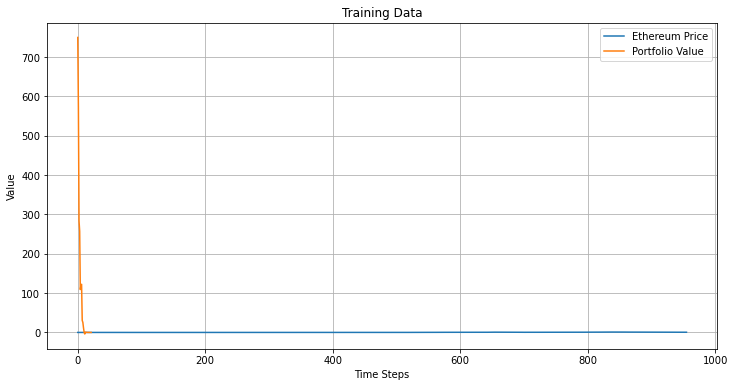

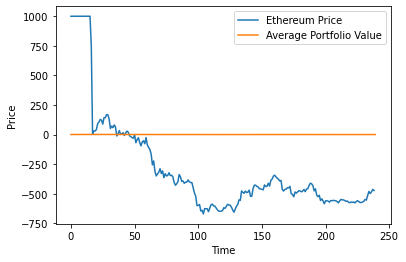

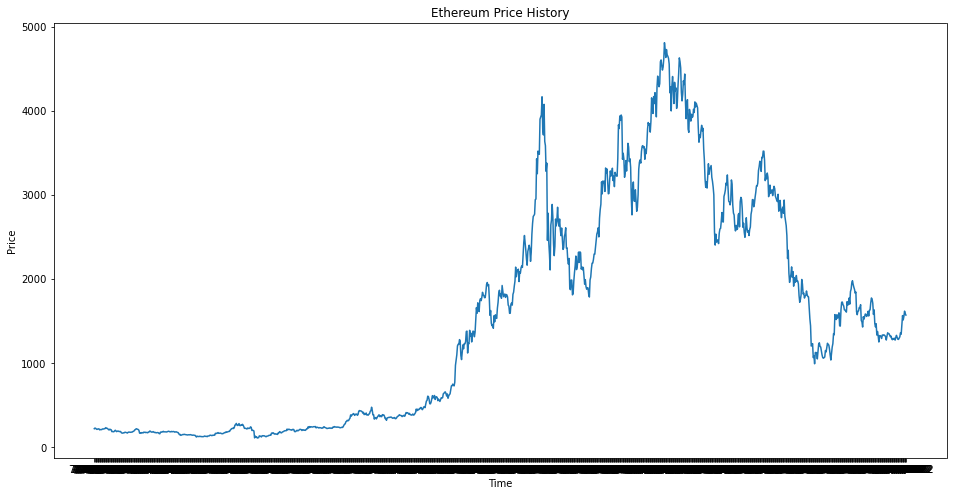

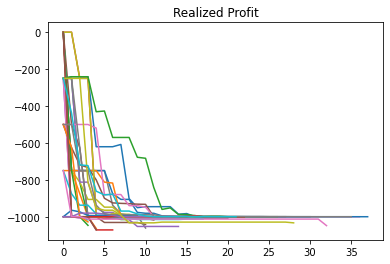

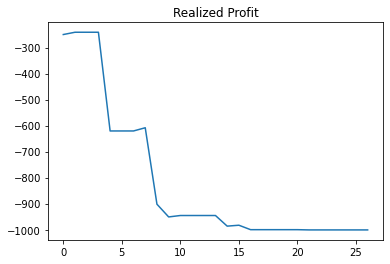

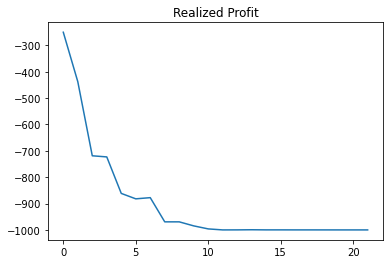

In [ ]:
import matplotlib.pyplot as plt

train_df, test_df, train_close, test_close = get_precollected_data(split_ratio=0.8)

def plot_data(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train_df["Close"], label="Ethereum Price")
    plt.plot(data["Portfolio Value (USD)"], label="Portfolio Value (USD)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
# visualize training data
with open('Output/episode_mem.json', 'r') as f:
    episode_mem = json.load(f)

with open("Output/testing_mem.json", "r") as f:
    testing_mem = json.load(f)

plot_data(episode_mem[29], "Training Data")
plt.show()

plt.plot((testing_mem["Portfolio Value (USD)"]))
plt.plot(test_df['Close'])
plt.legend(["Ethereum Price", "Average Portfolio Value (USD)"])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()
# plot ethereum price history
# set plot width and height
plt.figure(figsize=(16, 8))
plt.plot(historic_data["Close"])
plt.title("Ethereum Price History")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# # plot average portfolio value
# for i in range(NUM_EPISODES):
#     plt.plot(episode_mem[i]["Portfolio Value (USD)"])
# plt.legend(["Ethereum Price", "Average Portfolio Value (USD)"])
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.show()

# for i in range(NUM_EPISODES):
#     plt.plot(episode_mem[i]["Portfolio Value (USD)"])
# plt.title("Portfolio Value (USD)")
# plt.show()

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["Realized Profit"])
plt.title("Realized Profit")
plt.show()

plt.plot(episode_mem[0]["Realized Profit"])
plt.title("Realized Profit")
plt.show()

plt.plot(episode_mem[29]["Realized Profit"])
plt.title("Realized Profit")
plt.show()

# for i in range(NUM_EPISODES):
#     plt.plot(episode_mem[i]["Reward"])
# plt.title("Reward")
# plt.show()

# for i in range(NUM_EPISODES):
#     plt.plot(episode_mem[i]["Epsilon"])
# plt.title("Epsilon")
# plt.show()

# for i in range(NUM_EPISODES):
#     plt.plot(episode_mem[i]["MSE Loss"])
# plt.title("MSE Loss")
# plt.show()

# # visualize testing data
# with open('Output/testing_mem.json', 'r') as f:
#     testing_mem = json.load(f)

# # plot portfolio value vs ethereum price
# plt.plot(testing_mem["Portfolio Value (USD)"])
# plt.title("Portfolio Value (USD)")
# plt.show()

# plt.plot(testing_mem["Realized Profit"])
# plt.title("Realized Profit")
# plt.show()

# plt.plot(testing_mem["Reward"])
# plt.title("Reward")
# plt.show()